In [1]:
%run SetUpParams.ipynb
%run IncludePyTrendsData.ipynb

2024-09-17 02:10:03.031835
2004-09-17 02:10:03.031835


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [2]:
import pandas as pd
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler 
import seaborn as sns
import matplotlib.pyplot as plt

### Create dataframe for data exploration

In [3]:
explore_df = pd.DataFrame()
# Next Day Open Price - Current Day Open Price
explore_df[f'{target_stock}_change'] = target_stock_data['Open'].shift(-1) - target_stock_data['Open']
explore_df[f'{target_stock}_lag'] = explore_df[f'{target_stock}_change'].shift(1)
explore_df['Close'] = target_stock_data['Close']
explore_df['Price'] = target_stock_data['Open']
explore_df.reset_index(inplace=True)
# print(explore_df)

#### Add European and US Stock Market Price Changes to final_df
Current Day Open Price - Previous Day Open Price

In [4]:
# EU Stock Market has already opened
for ticker in US_EU_market_dict.keys():
        data = US_EU_market_dict[ticker]
        # Current Day Open Price - Previous Day Open Price
        temp = (data['Open'] - data['Open'].shift(1)).reset_index()
        temp.rename(columns={'Open':ticker}, inplace=True)
        explore_df = explore_df.merge(temp, on='Date', how='left')

#### Add Asian Stock Market Price Changes to final_df
Close Price - Open Price

In [5]:
# Asian Stock Market has already closed; one day ahead of US Stock Market
for ticker in asia_market_dict.keys():
        data = asia_market_dict[ticker]
        # Close Price - Open Price
        temp = (data['Close'] - data['Open']).reset_index()
        temp.rename(columns={0:ticker}, inplace=True)
        explore_df = explore_df.merge(temp, on='Date', how='left')

#### Merge explore_df with pytrends_data

In [6]:
explore_df['Month'] = explore_df['Date'].dt.month
explore_df['Year'] = explore_df['Date'].dt.year

explore_df = explore_df.merge(pytrends_data, on=['Month', 'Year'])
# Use previous day's relative difference of Bullish vs Bearish search term as independent variable
explore_df['Bullish_vs_Bearish_Diff'] = explore_df['Bullish_vs_Bearish_Diff'].shift(1)

In [7]:
# Different markets have different holidays
# Forward fill null values
explore_df.ffill(inplace=True)
explore_df.dropna(inplace=True, ignore_index=True)
# explore_df.isna().sum()

### Data Exploration

In [8]:
# Correlation matrix of f{target_stock}_change with all other variables
corr_target_lag = explore_df[f'{target_stock}_change'].corr(explore_df[f'{target_stock}_lag'])
print(corr_target_lag)
corr_ixic = explore_df[f'{target_stock}_change'].corr(explore_df['^IXIC'])
print(corr_ixic)
corr_dji = explore_df[f'{target_stock}_change'].corr(explore_df['^DJI'])
print(corr_dji)
corr_fchi = explore_df[f'{target_stock}_change'].corr(explore_df['^FCHI'])
print(corr_fchi)
corr_gdaxi = explore_df[f'{target_stock}_change'].corr(explore_df['^GDAXI'])
print(corr_gdaxi)
corr_aord = explore_df[f'{target_stock}_change'].corr(explore_df['^AORD'])
print(corr_aord)
corr_hsi = explore_df[f'{target_stock}_change'].corr(explore_df['^HSI'])
print(corr_hsi)
corr_n225 = explore_df[f'{target_stock}_change'].corr(explore_df['^N225'])
print(corr_n225)
corr_nsei = explore_df[f'{target_stock}_change'].corr(explore_df['^NSEI'])
print(corr_nsei)
corr_bull_vs_bear_diff = explore_df[f'{target_stock}_change'].corr(explore_df['Bullish_vs_Bearish_Diff'])
print(corr_bull_vs_bear_diff)

-0.03957712077459465
-0.015306747345792444
-0.028608501153932032
-0.03289212235553065
-0.04260465816481556
-0.008765586726200297
-0.028564371442982656
0.029754144331583996
-0.032247009601841375
0.04100120586103575


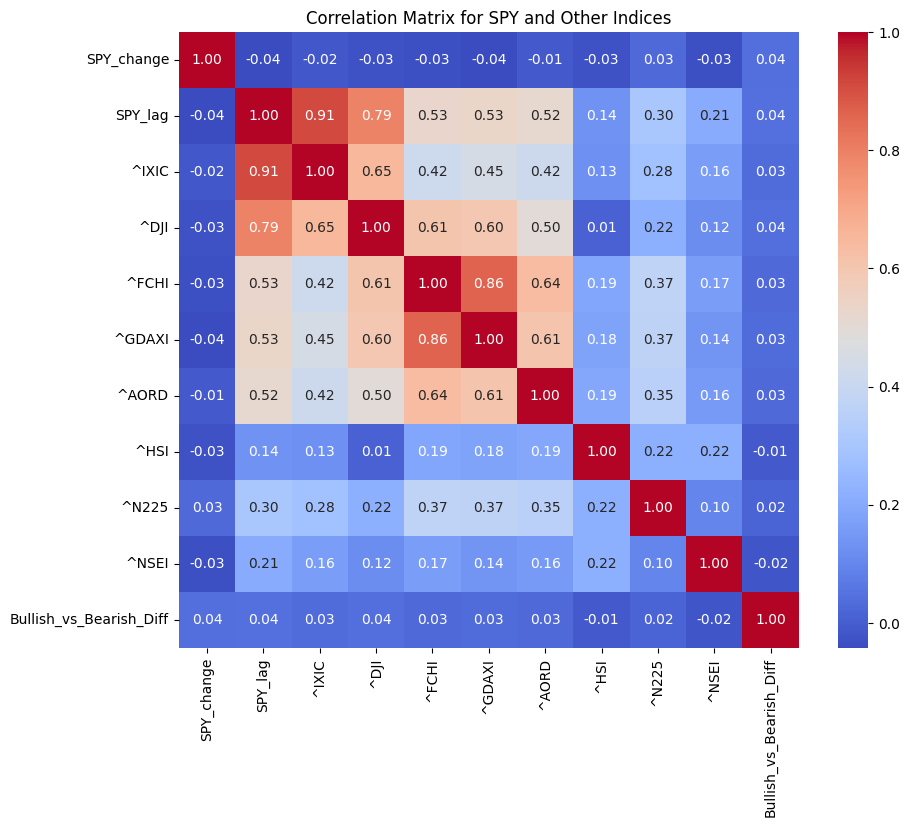

In [9]:
# Correlation matrix of all variables with each other
corr_df = explore_df.copy().drop(columns=['Date', 'Close', 'Price', 'Month', 'Year'])

corr_matrix = corr_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title(f'Correlation Matrix for {target_stock} and Other Indices')
plt.show()

In [10]:
# Check proportion of stock price changes in the same/opposite direction for input markets
def get_direction_of_stock_change(series1, series2):
    same_direction = 0
    opposite_direction = 0
    total = 0 
    for i in range(len(series1)):
        if series1[i] > 0 and series2[i] > 0:
            same_direction += 1
        elif series1[i] < 0 and series2[i] < 0:
            same_direction += 1
        elif series1[i] < 0 and series2[i] > 0:
            opposite_direction += 1
        elif series1[i] > 0 and series2[i] < 0:
            opposite_direction += 1
        total += 1
    return same_direction / total * 100, opposite_direction / total * 100

In [11]:
proportion_of_direction_target_lag = get_direction_of_stock_change(explore_df[f'{target_stock}_change'], explore_df[f'{target_stock}_lag'])
print(proportion_of_direction_target_lag)
proportion_of_direction_ixic = get_direction_of_stock_change(explore_df[f'{target_stock}_change'], explore_df['^IXIC'])
print(proportion_of_direction_ixic)
proportion_of_direction_dji = get_direction_of_stock_change(explore_df[f'{target_stock}_change'], explore_df['^DJI'])
print(proportion_of_direction_dji)
proportion_of_direction_fchi = get_direction_of_stock_change(explore_df[f'{target_stock}_change'], explore_df['^FCHI'])
print(proportion_of_direction_fchi)
proportion_of_direction_gdaxi = get_direction_of_stock_change(explore_df[f'{target_stock}_change'], explore_df['^GDAXI'])
print(proportion_of_direction_gdaxi)
proportion_of_direction_aord = get_direction_of_stock_change(explore_df[f'{target_stock}_change'], explore_df['^AORD'])
print(proportion_of_direction_aord)
proportion_of_direction_hsi = get_direction_of_stock_change(explore_df[f'{target_stock}_change'], explore_df['^HSI'])
print(proportion_of_direction_hsi)
proportion_of_direction_n225 = get_direction_of_stock_change(explore_df[f'{target_stock}_change'], explore_df['^N225'])
print(proportion_of_direction_n225)
proportion_of_direction_nsei = get_direction_of_stock_change(explore_df[f'{target_stock}_change'], explore_df['^NSEI'])
print(proportion_of_direction_nsei)

(50.292808620285776, 48.9107519325369)
(50.199109861794334, 49.37924572499414)
(50.08198641368003, 49.496369173108455)
(49.754040758959945, 49.847739517451394)
(48.98102600140548, 50.59732958538299)
(50.66760365425158, 48.79362848442258)
(49.56664324197704, 49.98828765518857)
(50.199109861794334, 49.37924572499414)
(50.36308268915437, 49.21527289763411)


### Remove ^GSPC_lag, DJI, ^FCHI, ^GDAXI 

In [12]:
US_EU_list = ["^IXIC"]
US_EU_market_dict = {}

asia_list = ["^AORD", "^HSI", "^N225", "^NSEI"]
asia_market_dict = {}

for ticker in US_EU_list:
    data = yf.download(ticker, start, today)
    US_EU_market_dict[ticker] = data

for ticker in asia_list:
    data = yf.download(ticker, start, today)
    asia_market_dict[ticker] = data

final_df = pd.DataFrame()
# Next Day Open Price - Current Day Open Price
final_df[f'{target_stock}_change'] = target_stock_data['Open'].shift(-1) - target_stock_data['Open']
final_df[f'{target_stock}_lag'] = final_df[f'{target_stock}_change'].shift(1)
final_df['Close'] = target_stock_data['Close']
final_df['Price'] = target_stock_data['Open']
final_df.reset_index(inplace=True)

# EU Stock Market has already opened
for ticker in US_EU_market_dict.keys():
    data = US_EU_market_dict[ticker]
    # Current Day Open Price - Previous Day Open Price
    temp = (data['Open'] - data['Open'].shift(1)).reset_index()
    temp.rename(columns={'Open':ticker}, inplace=True)
    final_df = final_df.merge(temp, on='Date', how='left')

# Asian Stock Market has already closed; one day ahead of US Stock Market
for ticker in asia_market_dict.keys():
    data = asia_market_dict[ticker]
    # Close Price - Open Price
    temp = (data['Close'] - data['Open']).reset_index()
    temp.rename(columns={0:ticker}, inplace=True)
    final_df = final_df.merge(temp, on='Date', how='left')

# Merge with pytrends_data
final_df['Month'] = final_df['Date'].dt.month
final_df['Year'] = final_df['Date'].dt.year
final_df = final_df.merge(pytrends_data, on=['Month', 'Year'])
# Use previous day's relative difference of Bullish vs Bearish search term as independent variable
final_df['Bullish_vs_Bearish_Diff'] = final_df['Bullish_vs_Bearish_Diff'].shift(1)

final_df.ffill(inplace=True)
final_df.dropna(inplace=True, ignore_index=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


### Prepare Sequences

In [13]:
input_df = final_df.copy().drop(columns=[f'{target_stock}_change', 'Date', 'Close', 'Price', 'Month', 'Year'])

In [14]:
# Train-Test Split
proportion_test = 0.8
gap = 60

output_df = final_df[f'{target_stock}_change'].to_frame()

train_index = round(len(input_df) * proportion_test)
test_index = train_index + gap

X_train = input_df.iloc[:train_index]
X_test = input_df.iloc[test_index:]

y_train = output_df.iloc[:train_index]
y_test = output_df.iloc[test_index:]

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3415, 7)
(794, 7)
(3415, 1)
(794, 1)


In [15]:
# Scaling inputs using Normalisation
scaler = StandardScaler()
X_scaled_train_temp = scaler.fit_transform(X_train)
X_scaled_train = pd.DataFrame(X_scaled_train_temp, columns = input_df.columns)

X_scaled_test_temp = scaler.fit_transform(X_test)
X_scaled_test = pd.DataFrame(X_scaled_test_temp, columns = input_df.columns)

In [16]:
def create_sequences(X_data, y_data, time_step = 10):
    X, y = [], []
    for i in range(len(X_data) - time_step):
        X.append(X_data.iloc[i:i + time_step, :].values)
        y.append(y_data.iloc[i+time_step, :].values)
    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)

In [17]:
X_train_seq, y_train_seq = create_sequences(X_scaled_train, y_train)
X_test_seq, y_test_seq = create_sequences(X_scaled_test, y_test)

In [18]:
# Shape of Tensor = (Number of Sequences, Time Steps, Number of Features)
print(X_train_seq.shape)
print(y_train_seq.shape)
print(X_test_seq.shape)
print(y_test_seq.shape)

torch.Size([3405, 10, 7])
torch.Size([3405, 1])
torch.Size([784, 10, 7])
torch.Size([784, 1])
